# Group 14 - Project FP01
## Time series anomaly detection - DAGMM

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *
from models_functions import *

# Set style for matplotlib
plt.style.use("Solarize_Light2")

import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#### Various parameters

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

file_name_normal = "_20220811_rbtc_"
file_name_collisions = "_collision_20220811_rbtc_"

recording_normal = [0, 2, 3, 4]
recording_collisions = [1, 5]

freq_str = freq.replace(".", "_")
features_folder_normal = f"./features/normal{freq_str}/"
features_folder_collisions = f"./features/collisions{freq_str}/"

### Data

In [4]:
df_features_normal, df_normal_raw, _ = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, None)
df_features_collisions, df_collisions_raw, df_collisions_raw_action = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, None)
df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, None)
df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, None)

Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
--- 169.65145587921143 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 62.10683345794678 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


--- 24.691510438919067 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 28.09510588645935 seconds ---


In [5]:
# df_features_normal, df_normal_raw, _ = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, f"{features_folder_normal}")
# df_features_collisions, df_collisions_raw, df_collisions_raw_action = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, f"{features_folder_collisions}1_5/")
# df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, f"{features_folder_collisions}1/")
# df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, f"{features_folder_collisions}5/")

In [6]:
X_train, y_train, X_test, y_test, df_test = get_train_test_data(df_features_normal, df_features_collisions, full_normal=True)
X_train_1, y_train_1, X_test_1, y_test_1, df_test_1 = get_train_test_data(df_features_normal, df_features_collisions_1, full_normal=True)
X_train_5, y_train_5, X_test_5, y_test_5, df_test_5 = get_train_test_data(df_features_normal, df_features_collisions_5, full_normal=True)

### Collisions

In [7]:
collisions_rec1, collisions_init1 = get_collisions('1', ROOTDIR_DATASET_ANOMALY)
collisions_rec5, collisions_init5 = get_collisions('5', ROOTDIR_DATASET_ANOMALY)

# Merge the collisions of the two recordings in one dataframe
collisions_rec = pd.concat([collisions_rec1, collisions_rec5])
collisions_init = pd.concat([collisions_init1, collisions_init5])

In [8]:
collisions_zones, y_collisions = get_collisions_zones_and_labels(collisions_rec, collisions_init, df_features_collisions)
collisions_zones_1, y_collisions_1 = get_collisions_zones_and_labels(collisions_rec1, collisions_init1, df_features_collisions_1)
collisions_zones_5, y_collisions_5 = get_collisions_zones_and_labels(collisions_rec5, collisions_init5, df_features_collisions_5)

## DAGMM for Anomaly Detection in Time Series Data

In [9]:
from algorithms.dagmm import DAGMM

classifier = DAGMM(
    num_epochs=10,
    lambda_energy=0.1,
    lambda_cov_diag=0.005,
    lr=1e-4,
    batch_size=32,
    gmm_k=5,
    normal_percentile=80,
    sequence_length=30,
    autoencoder_type=DAGMM.AutoEncoder.LSTM,  # Using LSTM autoencoder
    hidden_size=32,
    autoencoder_args={
        'n_layers': (4, 4),
        'use_bias': (True, True),
        'dropout': (0.1, 0.1)
    },
    seed=42,
    gpu=None,  # Set to None for CPU, or specify GPU index if available
    details=True
)

# Train the DAGMM on normal data
classifier.fit(X_train)
print("DAGMM training completed.")


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


DAGMM training completed.


### Predictions

Anomaly prediction completed.
Number of anomalies detected: 13 with threshold -10.588937846381754, std
Number of anomalies detected: 56 with threshold -14.115512895584107, mad
Number of anomalies detected: 16 with threshold -10.684459679325421, percentile
Number of anomalies detected: 0 with threshold -9.097109131018318, IQR
Number of anomalies detected: 0 with threshold 0.0, zero

choosen threshold type: mad, with value: -14.1155
F1 Score: 0.2484
Accuracy: 0.6046
Precision: 0.3571
Recall: 0.1905
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       201
           1       0.36      0.19      0.25       105

    accuracy                           0.60       306
   macro avg       0.51      0.51      0.49       306
weighted avg       0.56      0.60      0.57       306

ROC AUC Score: 0.4875


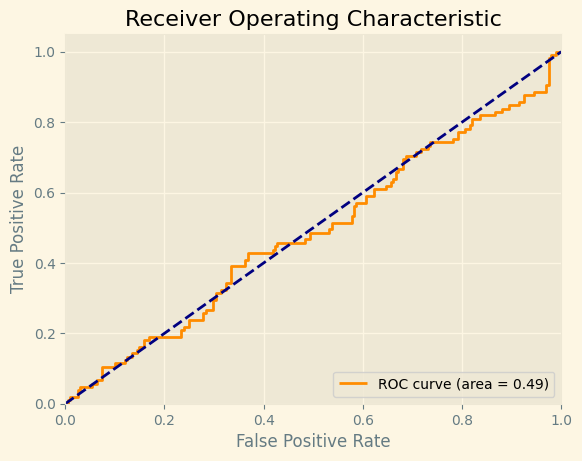

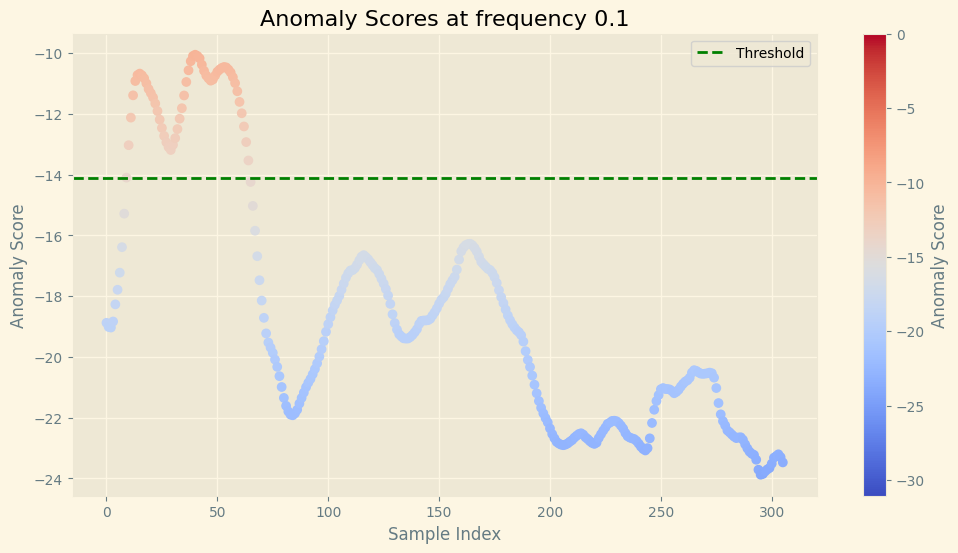

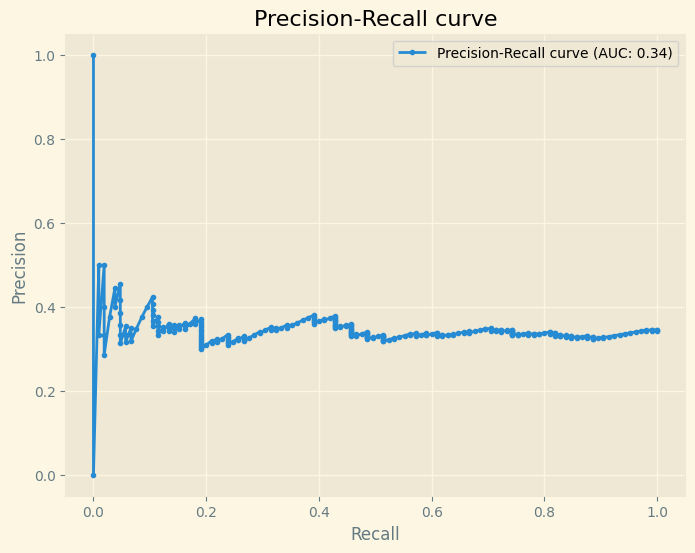

Anomalies detected: 56
Best threshold: -23.7673 | F1 Score: 0.5134 | Precision: 0.3454 | Recall: 1.0000
Anomalies detected with best threshold: 304

	-------------------------------------------------------------------------------------

Anomaly prediction completed.
Number of anomalies detected: 15 with threshold -10.306699277883123, std
Number of anomalies detected: 32 with threshold -15.557356902531222, mad
Number of anomalies detected: 9 with threshold -9.001748572985331, percentile
Number of anomalies detected: 28 with threshold -14.308327161714411, IQR
Number of anomalies detected: 0 with threshold 0.0, zero

choosen threshold type: mad, with value: -15.5574
F1 Score: 0.2985
Accuracy: 0.7134
Precision: 0.3125
Recall: 0.2857
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       129
           1       0.31      0.29      0.30        35

    accuracy                           0.71       164
   macro avg       0.56      0.56      0.56

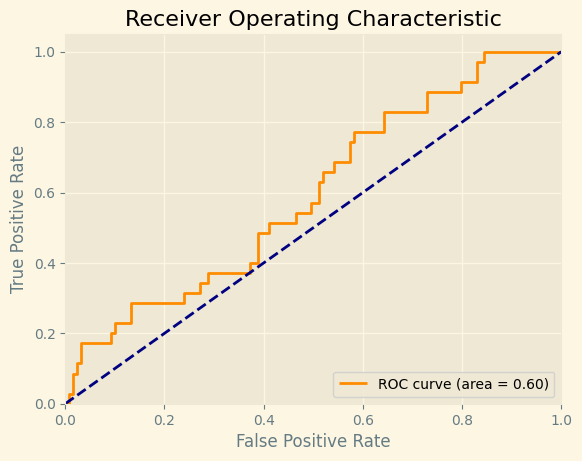

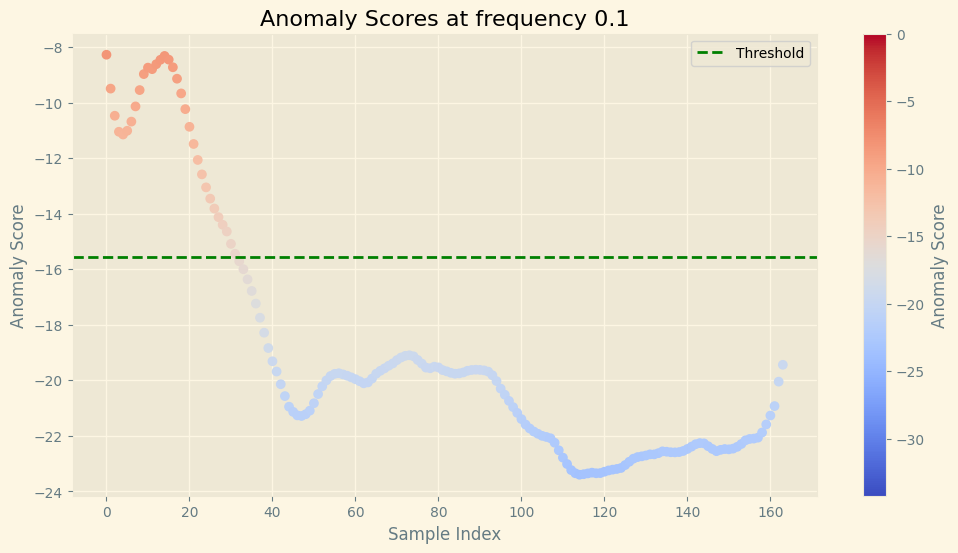

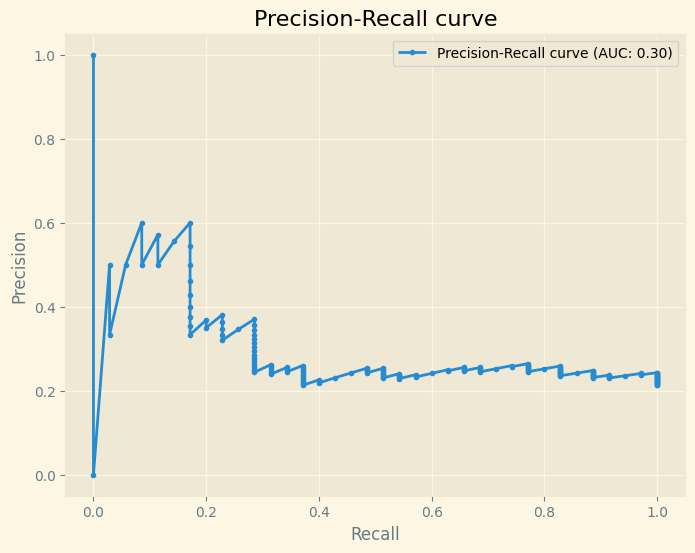

Anomalies detected: 32
Best threshold: -21.9987 | F1 Score: 0.3946 | Precision: 0.2589 | Recall: 0.8286
Anomalies detected with best threshold: 112

	-------------------------------------------------------------------------------------

Anomaly prediction completed.
Number of anomalies detected: 5 with threshold -13.011842276438324, std
Number of anomalies detected: 17 with threshold -14.6447734964305, mad
Number of anomalies detected: 8 with threshold -13.428368992275661, percentile
Number of anomalies detected: 0 with threshold -11.911651338849754, IQR
Number of anomalies detected: 0 with threshold 0.0, zero

choosen threshold type: mad, with value: -14.6448
F1 Score: 0.1370
Accuracy: 0.5532
Precision: 0.2941
Recall: 0.0893
              precision    recall  f1-score   support

           0       0.59      0.86      0.70        85
           1       0.29      0.09      0.14        56

    accuracy                           0.55       141
   macro avg       0.44      0.47      0.42   

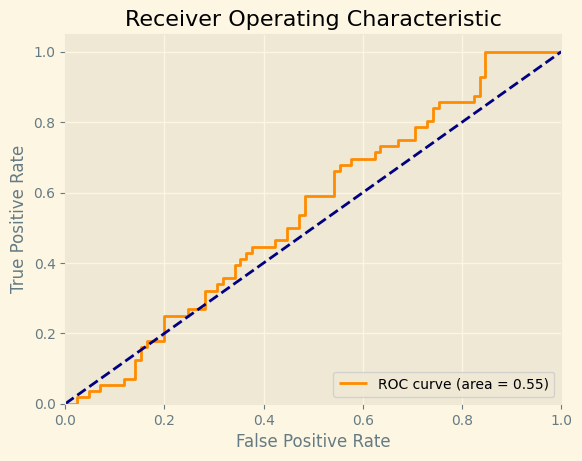

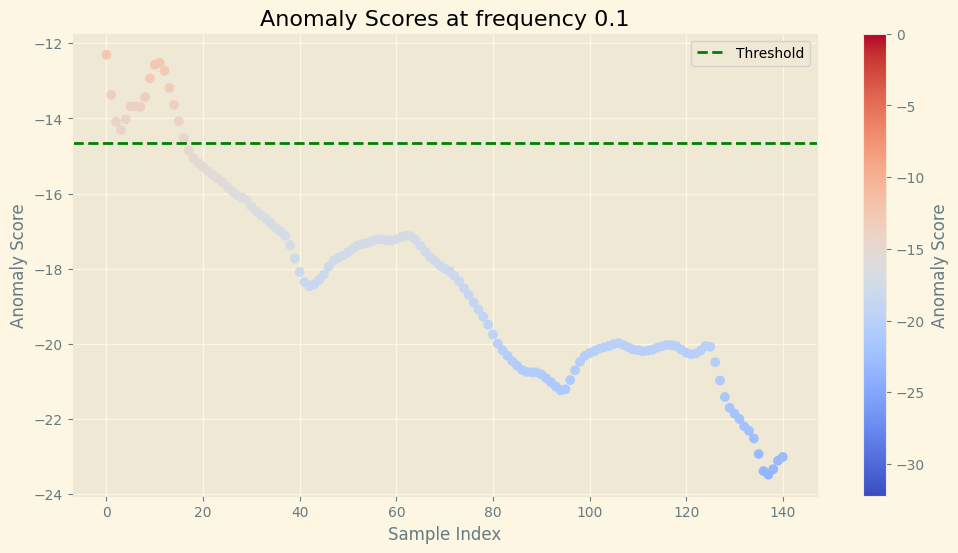

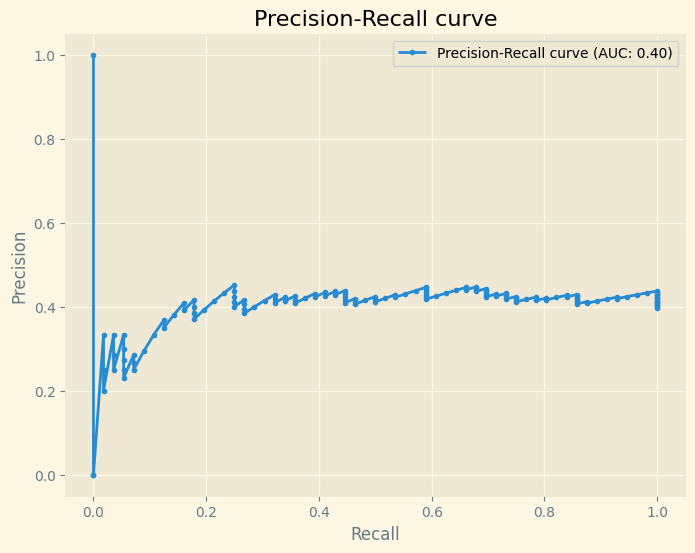

Anomalies detected: 17
Best threshold: -21.2319 | F1 Score: 0.6087 | Precision: 0.4375 | Recall: 1.0000
Anomalies detected with best threshold: 128

	-------------------------------------------------------------------------------------



In [10]:
df_test = get_statistics(X_test, y_collisions, classifier, df_test, freq, threshold_type="mad")
df_test_1 = get_statistics(X_test_1, y_collisions_1, classifier, df_test_1, freq, threshold_type="mad")
df_test_5 = get_statistics(X_test_5, y_collisions_5, classifier, df_test_5, freq, threshold_type="mad")

In [11]:
plot_anomalies_true_and_predicted(df_collisions_raw, df_collisions_raw_action, collisions_zones, df_test, title="Collisions zones vs predicted zones for both recordings")

In [12]:
plot_anomalies_true_and_predicted(df_collisions_raw_1, df_collisions_raw_action_1, collisions_zones_1, df_test_1, title="Collisions zones vs predicted zones for recording 1")

In [13]:
plot_anomalies_true_and_predicted(df_collisions_raw_5, df_collisions_raw_action_5, collisions_zones_5, df_test_5, title="Collisions zones vs predicted zones for recording 5")